# Bmad-X Numpy, Numba, Pytorch tests

In [1]:
#%load_ext autoreload
#%autoreload 2

In [2]:
from bmadx.track import make_track_a_drift, Particle, Drift

import numpy as np

import math

import matplotlib.pyplot as plt

In [3]:
c_light = 2.99792458e8 #speed of light in m/s
m_e = 0.510998950e6 #electron mass in eV

In [4]:
s = 0.0 #initial s
p0c = 4.0E+07 #Reference particle momentum in eV
mc2 = 1*m_e # electron mass in eV
#pvec1 = [2e-3,3e-3,-3e-3,-1e-3,2e-3,-2e-3] 

## Numpy

In [5]:
N_PARTICLE = 1_000_000


np.random.seed(999)

pvec0 = np.random.normal( size=(N_PARTICLE, 6), scale=.001)
np.std(pvec0[:, 0])

0.001000172002409757

In [6]:
P0 = Particle(pvec0[:,0],
              pvec0[:,1],
              pvec0[:,2],
              pvec0[:,3],
              pvec0[:,4],
              pvec0[:,5],
              s, p0c, mc2)
P0.x

array([ 0.00012716,  0.00156627, -0.00111006, ..., -0.00059041,
        0.00019104,  0.00101049])

In [7]:
track_a_drift = make_track_a_drift(np)
D1 = Drift(L=1)

In [8]:
P1 = track_a_drift(P0, D1)
np.std(P1.x)

0.0014156804429872186

In [9]:
%%timeit
P1 = track_a_drift(P0, D1)

15.7 ms ± 234 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Numba CPU

In [10]:
import numba
from numba import guvectorize, float64, jit

In [11]:
track_a_drift = make_track_a_drift(np)
#track_a_drift = numba.njit(make_track_a_drift(np))

In [12]:
#%%timeit
#track_a_drift(P0, D1)

In [13]:
params = D1
g = numba.njit( make_track_a_drift(np))

@guvectorize([(float64[:], float64[:])], '(n)->(n)', target='parallel')
def vg_parallel(a_in, a_out):
    p_in = Particle(x  = a_in[0],
                    px = a_in[1],
                    y  = a_in[2],
                    py = a_in[3],
                    z  = a_in[4],
                    pz = a_in[5],
                    s=s, p0c=p0c, mc2=mc2)
    p_out = g(p_in, params)
    a_out[0] = p_out.x
    a_out[1] = p_out.px    
    a_out[2] = p_out.y
    a_out[3] = p_out.py  
    a_out[4] = p_out.z
    a_out[5] = p_out.pz  
    

pvec1 = np.zeros_like(pvec0)      
vg_parallel(pvec0, pvec1)
np.std(pvec1[:,0])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


0.0014156804429872186

In [14]:
%%timeit
vg_parallel(pvec0, pvec1)

2.73 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
np.std(pvec1[:, 0])

0.0014156804429872186

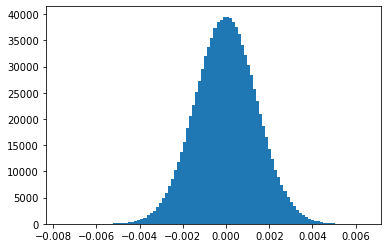

In [16]:
plt.hist(pvec1[:, 0], bins=100);

## PyTorch

In [17]:
import torch

In [18]:
tkwargs = {
    "dtype" : torch.double
}

In [19]:
track_a_drift = make_track_a_drift(torch)

In [20]:
tvec0= torch.tensor(pvec0, requires_grad=True, **tkwargs)
ts = torch.tensor(s, **tkwargs)
tp0c = torch.tensor(p0c, **tkwargs)
tmc2 = torch.tensor(mc2, **tkwargs)

tparticles0 = Particle(tvec0[:,0],
                tvec0[:,1],
                tvec0[:,2],
                tvec0[:,3],
                tvec0[:,4],
                tvec0[:,5],
                ts, tp0c, tmc2)

In [21]:
tparticles1 = track_a_drift(tparticles0, params)

tparticles1.x.std()

tensor(0.0014, dtype=torch.float64, grad_fn=<StdBackward0>)

In [22]:
%%timeit
tparticles1 = track_a_drift(tparticles0, params)

20.8 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
